<a href="https://colab.research.google.com/github/annachrome/Classifying_Flowers/blob/main/Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive to access files on Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary Python packages
import os
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
#from sklearn.preprocessing import LabelEncoder

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

Mounted at /content/drive


In [ ]:
root_dir = '/content/drive/MyDrive/Flowers/Dataset/'
image_dir = root_dir + 'Dataset_images/'
# image_files = [path for path in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, path))]
# print(len(image_files))


In [ ]:
mat_filepath = root_dir + 'Dataset_labels.mat'
mat_contents = scipy.io.loadmat(mat_filepath)

# # Find out 'labels' is stored as a 2D array
# print(mat_contents.keys())

labels_array =(mat_contents['labels'])[0]

# Ensure there are 8189 labels to match the 8189 images
print(f"There are {len(labels_array)} labels.")

# Find out there are 102 non-empty labels
unique_labels = np.unique(labels_array)
print(f"There are {len(unique_labels)} unique labels:\n {unique_labels}")

There are 8189 labels.
There are 102 unique labels:
 [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102]


In [ ]:
# Dataframe with each image index and its corresponding label index
df = pd.DataFrame(data={
    'img_idx': np.arange(1, len(labels_array)+1),
    'labels': labels_array.flatten()
})

df.head()

,img_idx,labels
0,1,77
1,2,77
2,3,77
3,4,77
4,5,77


In [ ]:
# Dataframe with each label index and the number of images with that label
counts_df = df['labels'].value_counts().sort_values(ascending=False).reset_index()
counts_df.columns = ['labels', 'count']
mean = counts_df['count'].mean().round(3)
std = counts_df['count'].std().round(3)
print(f"The number of images per label has a mean of {mean} and standard deviation of {std}.")

The number of images per label has a mean of 80.284 and standard deviation of 44.277.


Since the class sizes' standard deviation is very high relative to the mean, we must undersample large classes to reduce class imbalance.

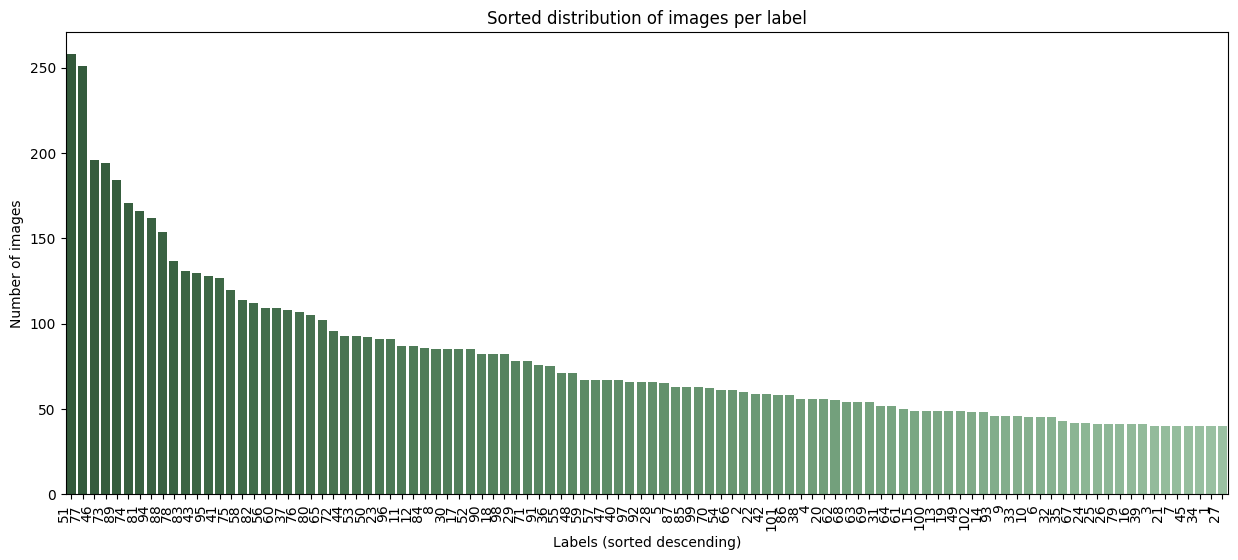

In [ ]:
plt.figure(figsize=(15,6))

palette = sns.cubehelix_palette(n_colors=df['labels'].nunique(),
                                start=2, rot=0, dark=0.7, light=0.3)

ax = sns.barplot(x='labels', y='count',
                 data=counts_df,
                 order=counts_df['labels'],
                 palette=palette)

plt.title('Sorted distribution of images per label')
plt.xticks(rotation=90, ha='right')
plt.xlabel('Labels (sorted descending)')
plt.ylabel('Number of images')
plt.show()

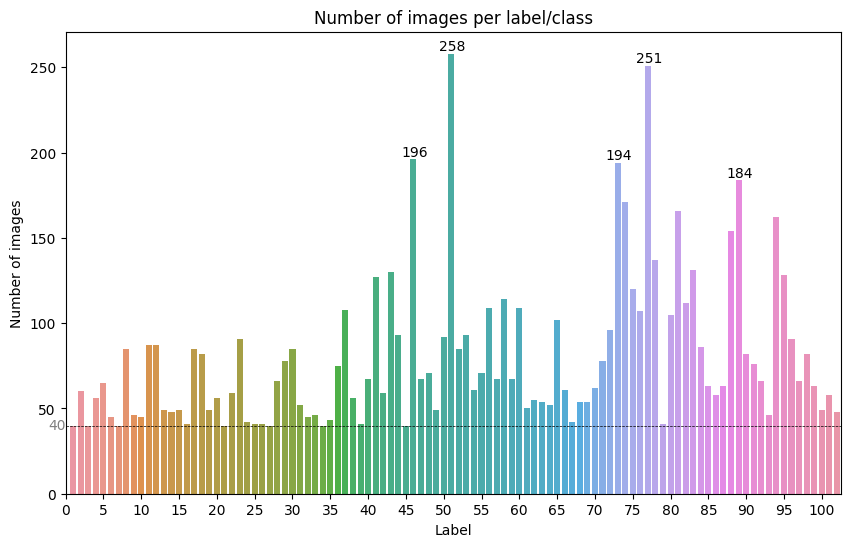

In [ ]:
# Plot the number of images per class
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='labels', data=df)

plt.title('Number of images per label/class')
plt.xlabel('Label')
plt.ylabel('Number of images')

# Setting x-ticks every 10 units, so bar labels don't overlap
plt.xticks(ticks=np.arange(-1, 102, 5), labels=np.arange(0, 102, 5))

# Draw horizontal line at count=40 since all classes should have 40+ images
ax.axhline(y=40, color='black', linestyle='--', linewidth=0.5)
ax.text(x=ax.get_xlim()[0], y=40, s='40', color='grey',
        verticalalignment='center', horizontalalignment='right')

# Find the label indices of the 5 largest classes
counts = df['labels'].value_counts()
largest_classes_lables = counts.index[:5]

# Annotate the 5 largest bars
for label_idx in largest_classes_lables:
    count = counts.loc[label_idx]
    ax.annotate(f'{count}', xy=(label_idx + 1, count), xytext=(-10, 0),
               textcoords='offset points', ha='center', va='bottom')

In [ ]:
# Check all images are in jpg

def get_unique_extensions(directory):
    '''
    Finds all unique file extensions of a directory
    '''
    unique_extensions = set()

    for foldername, subfolders, filenames in os.walk(image_dir):
        for filename in filenames:
            _, extension = os.path.splitext(filename)
            unique_extensions.add(extension)

    return unique_extensions

unique_extensions = get_unique_extensions(image_dir)
print("Unique Extensions:", unique_extensions)

Unique Extensions: {'.jpg'}


In [ ]:
# Add height and width of each image to Dataframe df

def get_img_dims(img_idx, image_dir):
    idx_str = str(img_idx)
    image_name = "image_" + idx_str.rjust(5, '0')
    image_path = os.path.join(image_dir, image_name + '.jpg')

    try:
        image = Image.open(image_path)
        return image.size  # Returns (width, height)
    except FileNotFoundError:
        return (None, None)  # Returns (None, None) if the image file is not found


df[['width', 'height']] = df['img_idx'].apply(get_img_dims, image_dir=image_dir).tolist()

df.head()

,img_idx,labels,width,height
0,1,77,591,500
1,2,77,625,500
2,3,77,500,667
3,4,77,667,500
4,5,77,508,500


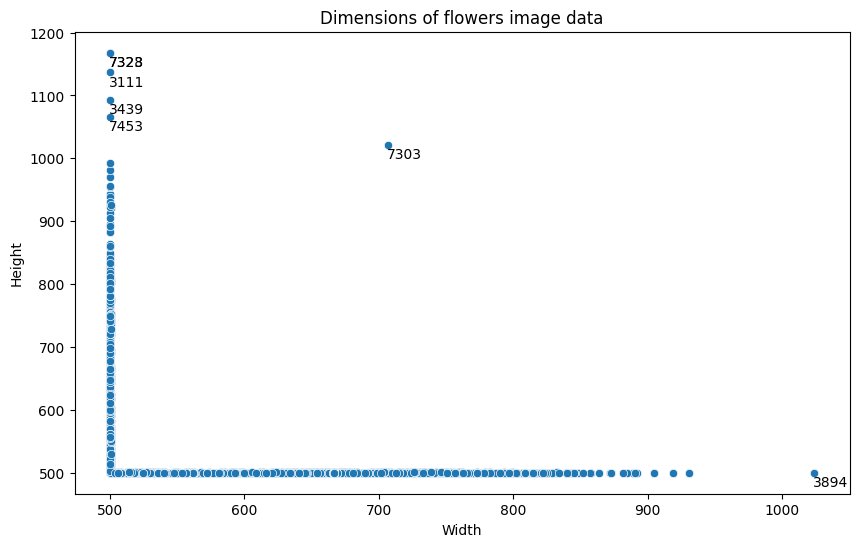

In [ ]:
# Scatter plot of image height-width ratios
plt.figure(figsize=(10,6))
sns.scatterplot(x='width', y='height', data=df)
plt.title('Dimensions of flowers image data')
plt.xlabel('Width')
plt.ylabel('Height')

for idx, row in df.iterrows():
    if (row['width'] >= 600 and row['height'] >= 1000) or (row['width'] >= 1000) or (row['height'] >= 1000):
        plt.annotate(row['img_idx'], (row['width'], row['height']), textcoords='offset points', xytext=(12,-10), ha='center')

plt.show()

Since image dimensions vary greatly, resizing all images to a fixed size, e.g. (224, 224), may cause an image with (WLOG) width < height to lose a disproportionate amount of information along the height axis.

Hence, dynamically resize and pad the images to maintain their original aspect ratios.

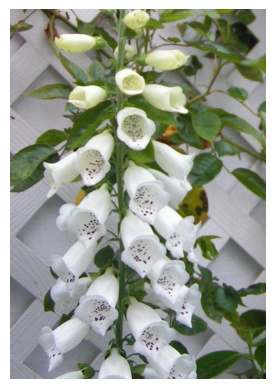

In [ ]:
idx_str = str(7303)
image_name = "image_" + str(7303).rjust(5, '0')
image_path = image_dir + image_name + '.jpg'

image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()